{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Replace (masked) values in one xarray DataArray with values in another array.

</div>

Sometimes you have many bad pixels in a landsat scene that you wish to replace or fill in with pixels from another scene. In this lesson you will learn how to replace pixels in one scene with those from another using Xarray. 

To begin, open both of the pre-fire raster stacks. You got the cloud free data as a part of your homework, last week. The scene with the cloud is in the cold spring fire data that you downloaded last week. 

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from numpy import ma
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
data_2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

First, import the landsat rasters and mask out the clouds like you did in the previous lesson. 

In [2]:
# Custom function to read in list of tifs into an xarray object
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"]=i+1
     
    return xr.concat(out_xr, dim="band") 

# Stack the Landsat pre fire data
landsat_paths_pre_path = os.path.join("cold-springs-fire", 
                                      "landsat_collect",
                                      "LC080340322016070701T1-SC20180214145604", 
                                      "crop",
                                      "*band[2-4]*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

landsat_pre_cloud = combine_tifs(landsat_paths_pre)


# Calculate bounds object
landsat_pre_cloud_ext_bds = landsat_pre_cloud.rio.bounds()

# Open the pixel_qa layer for your landsat scene
landsat_pre_cl_path = os.path.join("cold-springs-fire", 
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604", 
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

# Generate array of all possible cloud / shadow values
cloud_shadow = [328, 392, 840, 904, 1350]
cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
high_confidence_cloud = [480, 992]

vals_to_mask = cloud_shadow + cloud + high_confidence_cloud

# Call the earthpy mask function using pixel QA layer
landsat_pre_cloud_masked = landsat_pre_cloud.where(~landsat_qa.isin(vals_to_mask))

Plot the data to ensure that the cloud covered pixels are masked. 

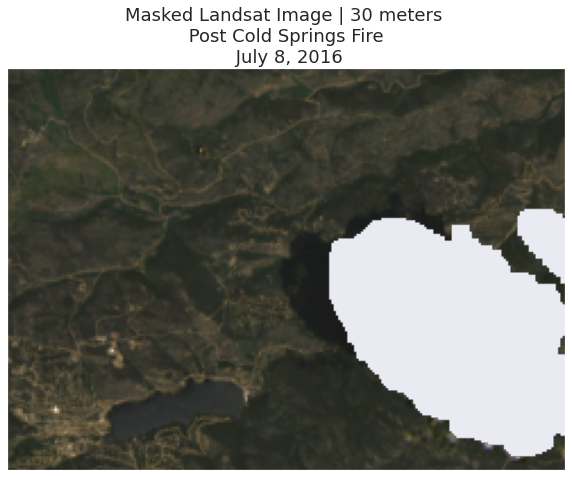

In [3]:
# Masking out NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cloud_masked_plot = ma.masked_array(landsat_pre_cloud_masked.values, landsat_pre_cloud_masked.isnull())

ep.plot_rgb(landsat_pre_cloud_masked_plot,
            rgb=[2, 1, 0],
            title="Masked Landsat Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()

### Read and Stack Cloud Free Data
Next, read in and stack the cloud free landsat data. 
Below you access the `bounds` object of a rioxarray object with `xarray_name.rio.bounds()`. This contains the spatial extent of the cloud free raster. You will use this to ensure that the bounds of both datasets are the same before replacing pixel values. 

In [4]:
# Read in the "cloud free" landsat data that you downloaded as a part of your homework
# I believ e this is the post fire data - remove this??
#path_landsat_pre_st_clfree = "data/cold-springs-fire/outputs/landsat_pre_clfree.tif"
# landsat_paths_pre_clfree = glob(
#     "data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/*band*.tif")
# landsat_paths_pre_clfree.sort()

# # Stack the data
# landsat_pre_nocloud, landsat_pre_nocloud_meta = es.stack(
#     landsat_paths_pre_clfree)

# Read in the pre-fire landsat data (this data has clouds)
# with rio.open(path_landsat_pre_st_clfree) as ff:
#     landsat_pre_nocloud = ff.read(masked=True)
#     landsat_clfree_bounds = ff.bounds
#     landsat_clfree_crs = ff.crs

In [5]:
# Read in the "cloud free" landsat data that you downloaded as a part of your homework
landsat_paths_pre_cloud_free = glob(
    os.path.join("cs-test-landsat", "*band[2-4]*.tif"))

landsat_paths_pre_cloud_free.sort()

landsat_pre_cloud_free = combine_tifs(landsat_paths_pre_cloud_free)


# Calculate bounds object
landsat_no_clouds_bds = landsat_pre_cloud_free.rio.bounds()

In [6]:
# plotting_extent isn't generating the correct extent for some reason
# remember that for extents you need to use ust a single band...
# no_clouds_ext = plotting_extent(
#     landsat_pre_clfree[0], landsat_pre_clfree_meta["transform"])
# # is stack not working OR is there something else up?
# ep.plot_rgb(landsat_pre_clfree, extent=no_clouds_ext)


# you can calculate the bounds this way using rasterio:
# height = landsat_pre_cloud_free.shape[1]
# width = landsat_pre_cloud_free.shape[2]
# transform = landsat_pre_cloud_free_meta["transform"]
# rio.transform.array_bounds(height, width, transform)

In [7]:
# Are the bounds the same?
landsat_no_clouds_bds == landsat_pre_cloud_ext_bds

False

In [8]:
# Make polygons from the bounds
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)

# Do the data overlap spatially?
cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

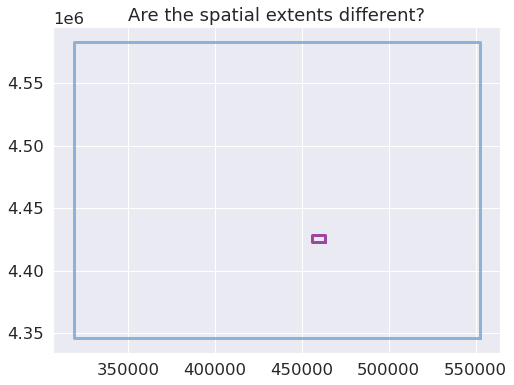

In [9]:
# Plot the boundaries
x, y = cloud_free_scene_bds.exterior.xy
x1, y1 = cloudy_scene_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.plot(x1, y1, color='purple', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.set_title('Are the spatial extents different?')

plt.show()

In [10]:
# Is the CRS the same in each raster?
landsat_pre_cloud.rio.crs == landsat_pre_cloud_free.rio.crs

True

In [11]:
# Are the shapes the same?
landsat_pre_cloud.shape == landsat_pre_cloud_free.shape

False

You've now determined that

1. the data do not have the same bounds
2. the data are in the same Coordinate Reference System and
3. the data do overlap (or intersect).

Since the two images do not cover the same spatial extent, the next step is to CROP the cloud-free data (which has a larger spatial extent) to the spatial extent of the cloudy data so we can then reassign all cloud covered pixels to the values in the cloud free data (in the same location).

In [12]:
# Turn the cloud free data boundary into a geojson object for clipping
# landsat_clouds_clip = mapping(box(landsat_pre_cloud_ext[0],
#                            landsat_pre_cloud_ext[2],
#                            landsat_pre_cloud_ext[1],
#                            landsat_pre_cloud_ext[3]))

# Export the cloud free data as a tiff and reimport / crop the data
# landsat_cloud_free_out_path = os.path.join("data", "outputs", "cloud_mask")

# if not os.path.exists(landsat_cloud_free_out_path):
#     os.makedirs(landsat_cloud_free_out_path)

# cropped_cloud_list = es.crop_all(landsat_paths_pre_cloud_free,
#                                  landsat_cloud_free_out_path,
#                                  [landsat_clouds_clip], overwrite=True)

# landsat_pre_cloud_free, landsat_pre_clod_free_meta = es.stack(
#     cropped_cloud_list)

In [13]:
landsat_clouds_clip = es.extent_to_json(list(landsat_pre_cloud_ext_bds))

In [14]:
# Clip the data to the extent of the other landsat scene

landsat_pre_cloud_free = landsat_pre_cloud_free.rio.clip([landsat_clouds_clip])

In [15]:
# View the shape of each scene. are they the same?
landsat_pre_cloud_free.shape, landsat_pre_cloud_masked.shape

((3, 177, 246), (3, 177, 246))

In [16]:
# set all mask values to -9999
#np.ma.filled(landsat_pre_cloud, fill_value=-999)
# assign values of -999 to mask = true
#new_masked_array = np.ma.masked_values(array_a, -9999)
# get the mask from the array

Once the data are cropped to the same extent, you can replace values using xarray's `where()` function.

In [17]:
# Get the mask layer from the pre_cloud data
mask = landsat_pre_cloud_masked.isnull()

# Assign every cell in the new array that is masked
# to the value in the same cell location as the cloud free data
landsat_pre_cloud_masked_val_replace = xr.where(mask, landsat_pre_cloud_free, landsat_pre_cloud_masked)

Finally, plot the data. Does it look like it reassigned values correctly?

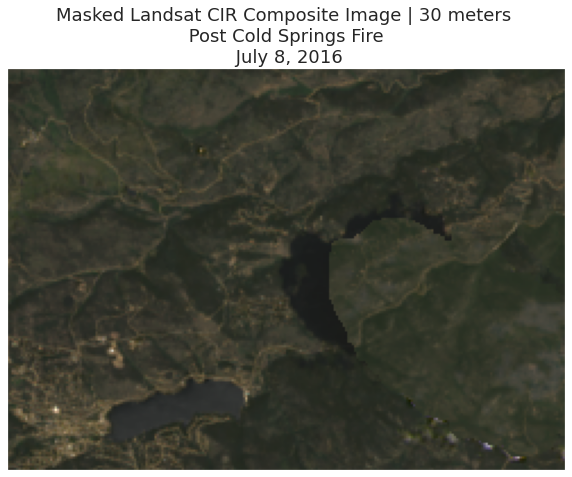

In [18]:
# Masking out NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cloud_masked_val_replace_plot = ma.masked_array(landsat_pre_cloud_masked_val_replace.values, landsat_pre_cloud_masked_val_replace.isnull())

ep.plot_rgb(landsat_pre_cloud_masked_val_replace_plot,
            rgb=[2, 1, 0],
            title="Masked Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()

The above answer is not perfect! You can see that the boundaries of the masked area are still visible. Also there are dark shadowed pixels that were not replaced given the raster `pixel_qa` layer did not assign those as pixels to be masked. Thus you may need to do a significant amount of further analysis to get this image to where you'd like it to be. But you at least have a start at getting there!

In the case of this class, a large enough portion of the study area is covered by clouds that it makes more sense to find a new scene with cloud cover. However, it is good to understand how to replace pixel values in the case that you may need to do so for smaller areas in the future. 


In [19]:
# Note code below replicates the cover function in R using numpy arrays
array_a = np.array([[[0.564, -999, -999],
                     [0.234, -999, 0.898],
                     [-999, 0.124, 0.687],
                     [0.478, 0.786, -999]],
                    [[0.564, -999, -999],
                     [0.234, -999, -999],
                     [-999, -999, 0.687],
                     [0.478, 0.786, -999]]], np.float16)

array_b = np.array([[[0.324, 0.254, 0.204],
                     [0.469, 0.381, 0.292],
                     [0.550, 0.453, 0.349],
                     [0.605, 0.582, 0.551]],
                    [[0.324, 0.954, 0.404],
                     [0.469, 0.381, 0.292],
                     [0.550, 0.453, 0.349],
                     [0.605, 0.582, 0.551]]])

new_array = np.copy(array_a)

# Assign values of -999 to mask = true
new_masked_array = np.ma.masked_values(array_a, -999)

# Get the mask from the array
new_masked_array.mask
new_array[new_masked_array.mask] = array_b[new_masked_array.mask]